# Distributed XGBoost with Dask on CML

In this notebook we'll demonstrate a simple application of detecting credit card fraud by training a distributed XGBoost model using Dask distributed computing. 

Code examples drawn in part from the [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html) and [this blog post](https://medium.com/rapids-ai/a-new-official-dask-api-for-xgboost-e8b10f3d1eb7) published by RAPIDS AI, both excellent sources of information for further details. 



In [2]:
import os
import time

import cdsw
import xgboost as xgb
import dask.array as da
from dask import dataframe as dd
import dask_ml
from dask.distributed import Client

from utils.dask_utils import run_dask_cluster

import sklear

In [ ]:
!pip install seaborn
import seaborn as sns

In [2]:
NUM_WORKERS=3
CPU_PER_WORKER=1
MEM_PER_WORKER=2

In [3]:
dask_cluster = run_dask_cluster(num_workers=NUM_WORKERS, cpu=CPU_PER_WORKER, memory=MEM_PER_WORKER)

In [15]:
dask_cluster.keys()

dict_keys(['scheduler', 'workers', 'scheduler_address'])

In [4]:
client = Client(dask_cluster['scheduler_address'])

In [5]:
client

<Client: 'tcp://100.66.128.5:8786' processes=3 threads=24, memory=5.54 GiB>

In [6]:
print("//".join(dask_cluster['scheduler'][0]["app_url"].split("//")) + "status")

https://ckaemamlggjplewz.fflab-4.cdsw-int.cloudera.com/status


In [18]:
client

<Client: 'tcp://100.66.128.5:8786' processes=3 threads=24, memory=5.54 GiB>

## Get some data

In this example we'll be using the [HIGGs data](https://archive.ics.uci.edu/ml/datasets/HIGGS) from the UCI Machine Learning Repository. This binary classification dataset contains 11 million samples consisting of 28 features for each sample.  This dataset is quite large and likely won't fit in memory  as it requires nearly 8GiB on disk (and we've suggested that you run this notebook with only 2 GiB). This is a prime example of a time when distributed training will serve us well - when our local RAM or computational resources are not sufficient for the task at hand.  


In the cells below we download the dataset and unzip it (Dask DataFrames don't play nice with zipped data formats).

Next we load the data into a Dask Dataframe. From the data description, we know the first column is the label, with all other columns being features. 

In [3]:
dask_df = dd.read_csv("data/creditcard.csv", assume_missing=True)

We now have a Dask DataFrame. These objects mimic much, but not all, of the functionality of a traditional Pandas DataFrame. We can take a look at the object we have, but it's not very interesting yet. This is because Dask operations are lazily evaluated, that is, no computations are performed until explicitly asked for by calling `.compute()`. Dask is _lazy_ in everything it does, including reading in the actual values of the dataset.

On the other hand, Dask is especially good at determining how to read data in, once called to do so. Spefically, Dask has determined that these 11 million samples should be chunked into 125 partitions, with each partition containing about 88,000 samples each. Because none of the data has yet been loaded into memory, we see only the structure of the DataFrame, rather than the values. 

In [4]:
dask_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


To see the values themselves we must force Dask to execute a computation. Calling `head()` on the DataFrame executes a `.compute()` operation under the hood which in turn loads the data from the first partiion and displays the top 5 values. 

In [5]:
dask_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### Data Prep

In an unrealistic (but possibly good) assumption, we'll exclude the time variable and treat the remaining features as i.i.d. over that time. It's possbile that fraudulent transactions are more likely at a certain time - even if so, creating a classifier that discriminates on the basis of time presents an easily-exploitable means of improving the likelihood of a successful fraudulent transaction, as an adversary. It's likely that time is confounded with the other variables from which features were derived. Unfortunately, we have no way of knowing. Causal inference always requires model assumptions, and is impossible with obfuscated variables.


In [6]:
dask_df = dask_df.drop(columns=['Time'])

The target class is heavily imbalanced -- this is expected since (hopefully) fraudulent transactions are a rare occurance!

In [39]:
class_counts = dask_df.Class.value_counts().compute()

print(f"""There are {class_counts[1]} identified cases of fraud in {class_counts.sum()} total cases. 
        That's only {100 * class_counts[1]/class_counts.sum():.2f}%!""")

There are 492 identified cases of fraud in 284807 total cases. 
        That's only 0.17%!


Maybe some features will be well correlated with the target. Let's do a visual spot check. Because there's such a huge class imbalance, we randomly downsample the dominant class to match the prevalence of the minority class.

In [72]:
sample_df = dd.concat([dask_df[dask_df.Class == 1], dask_df[dask_df.Class == 0].sample(frac=0.0017)]).compute().reset_index()

Now that we've created a small sample, we can convert this to a standard pandas dataframe for use in our plotting function. 

In [73]:
melted_cc = (
    sample_df
    .drop("Amount", axis="columns")
    .melt(id_vars=["Class"],
          value_vars=[c for c in dask_df.columns if c not in ["Class", "Amount"]])
)

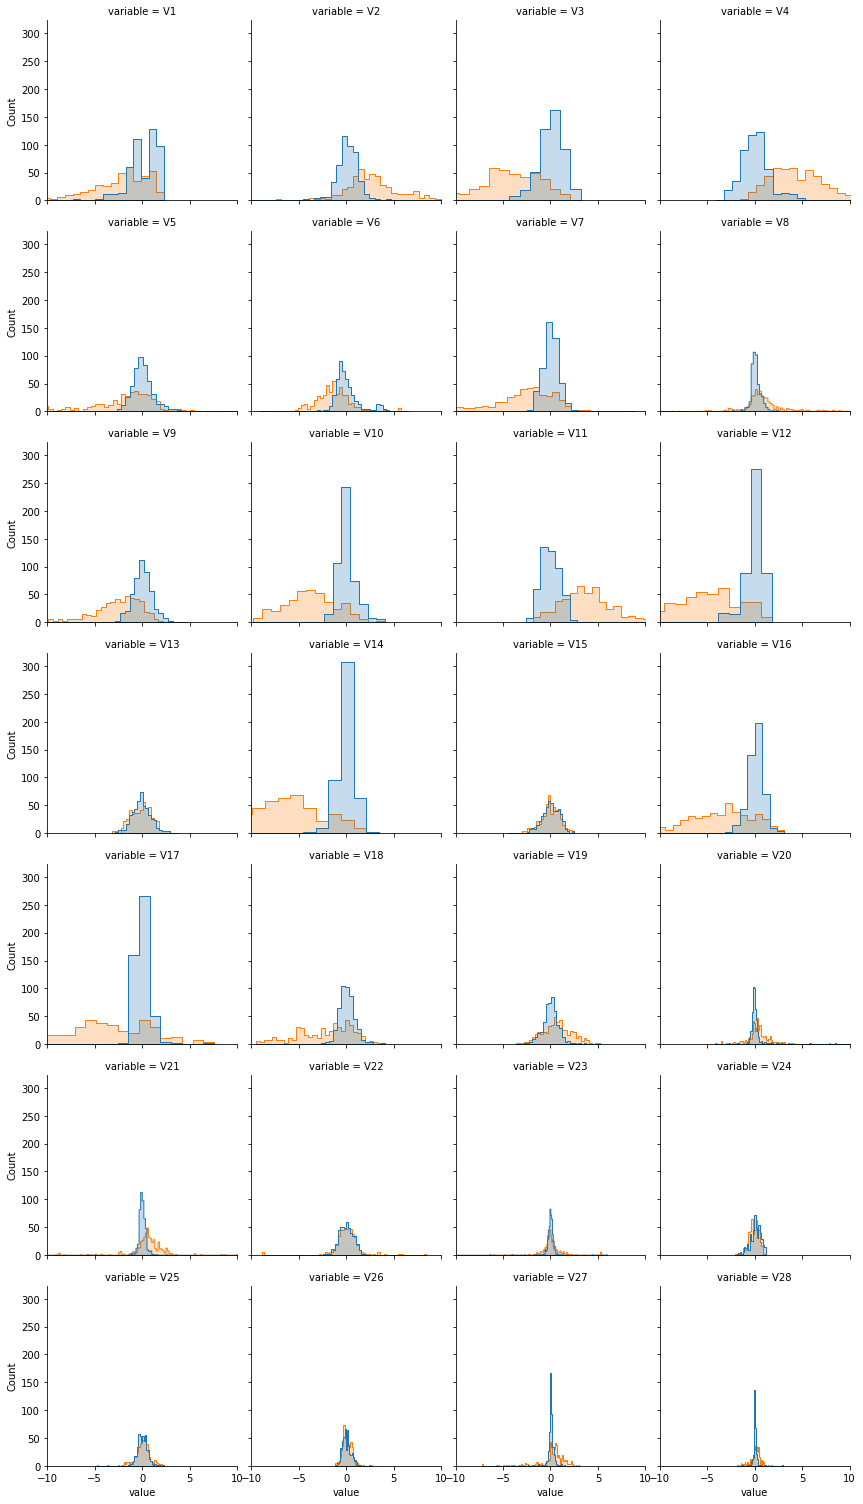

In [74]:
grid = sns.FacetGrid(melted_cc, col="variable", col_wrap=4)
grid.map_dataframe(sns.histplot, x="value", hue="Class", element="step")
grid.set(xlim=(-10,10))

<AxesSubplot:xlabel='Amount', ylabel='Count'>

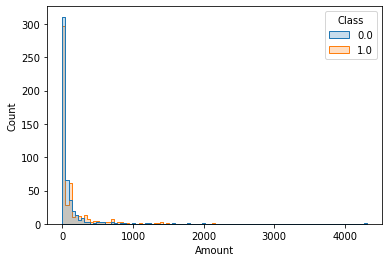

In [75]:
sns.histplot(
    sample_df,
    x="Amount", hue="Class", element="step", bins=100
)

The distribution of fraudulent transactions looks relatively well spread over the transaction size (recalling that downsampling non-fraudulent transactions so severely introduces a lot of statistical noise - run the function repeatedly to draw new samples). It looks like there's some reasonable separation between some of the PCA feature distributions though. This signals that there's a good chance we can learn to discriminate fraudulent transactions on the basis of these features. (Even those distributions that overlap extremely well may be useful in combination with other features).

### Train/dev/validation split

Before we compute anything, even baselines, let's establish a train test split. We'll do 70% train, 20% dev, and 10% validation. 

In [77]:
# Class is our target variable so we separate this column from the dask dataframe
y = dask_df['Class']
X = dask_df[dask_df.columns.difference(['Class'])]

In [79]:
X_train, X_dev, y_train, y_dev = dask_ml.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)
X_dev, X_val, y_dev, y_val = dask_ml.model_selection.train_test_split(X_dev, y_dev, test_size=0.333, shuffle=True)

Let's verify that our splits contain class imbalances that are approximately proportionally to our original dataset

In [85]:
print(y_train.sum().compute() / len(X_train.compute()))
print(y_dev.sum().compute() / len(X_dev.compute()))
print(y_val.sum().compute() / len(X_val.compute()))

0.001714466184410389
0.0017354415734670266
0.0018032670956792307


### Baselines

In [97]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as sklearn_SScaler

from dask_ml.preprocessing import StandardScaler as dask_SScaler

In [98]:
baseline_pipeline = Pipeline([
    ('scaler', dask_SScaler()),
    ('majority_classifier', DummyClassifier(strategy="most_frequent"))
])

baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('majority_classifier',
                 DummyClassifier(strategy='most_frequent'))])

In [99]:
print("Score on the train set:", baseline_pipeline.score(X_train, y_train))
print("Score on the dev set:", baseline_pipeline.score(X_dev, y_dev))

Score on the train set: 0.9982855338155896
Score on the dev set: 0.9982645584265329


In [87]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty="none"))
])

In [89]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(penalty='none'))])

In [94]:
def area_under_pr_curve(classifier, X, y):
    precision, recall, _ = precision_recall_curve(classifier.predict(X), y)
    area = auc(recall, precision)
    return area

In [95]:
area_under_pr_curve(logistic_pipeline, X_train, y_train)

0.751465283125239

In [96]:
area_under_pr_curve(logistic_pipeline, X_dev, y_dev)

0.7332526418738095

## From Dask DataFrames to DMatrices

This implmentation of XGBoost requires data in a specialized format called a DMatrix. This data object has been especially optimized to be memory efficient. 

Below, we perform an operation that converts a Dask DataFrame to a Dask DMatrix. Under the hood, this process may place one or more DataFrame partitions onto one or more DMatrix objects.  

![DMatrix](images/Dask_DMatrix.png)

This takes a while because we are literally moving the data around now, and there's a lot of data to shuffle!

In [57]:
# X and y must be Dask dataframes or arrays

dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)

## Train the model
With the data in an ingestible format, it's time to train our XGBoost model. The training call is similar to non-distributed calls to XGBoost but with one key difference -- we now pass in the Dask Client, which is responsible for orchestrating the training across the Dask cluster. 


Link to more parameters for the model

In [58]:
output = xgb.dask.train(
    client,
    {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
    dtrain,
    num_boost_round=4,
    evals=[(dtrain, "train")],
)

In [59]:
output

{'booster': <xgboost.core.Booster at 0x7f62ed5a3bb0>,
 'history': {'train': OrderedDict([('rmse',
                [0.3502626987966704,
                 0.24551773050153097,
                 0.1723433029647616,
                 0.12124685368142686])])}}

This the model -- let's save the model for later use. 


In [ ]:
# save the model to disk


### Evaluation

During the iterative process of ML modeling, we'll want to evaluate our model on the training and validations sets in order to ascertain our bias-variance trade-off.  Because our train set is quite large, this is still a good job for distributed cluster. 


We can score our model by passing our DaskDMatrix object to the xgb.dask.predict method. The result is another Dask Array so we must use `.compute()` to retrieve a non-distributed data object (e.g., a Numpy array)

In [2]:
# read the model back in

In [88]:
prediction = xgb.dask.predict(client, output, dtrain)

In [89]:
pred = prediction.compute()

In [99]:
labels = [round(t) for t in pred]
len(labels)

88000

In [92]:
y_pred = y_train.compute()

In [101]:
sum(labels == y_pred)/len(labels)

0.7045340909090909

### Validation

Not Implemented yet.

## Inference

Once we have an evaluated model that we're happy with, we can use it for inference like we would any model -- with or without distributed computational resources. 

Not implemented yet

In [3]:
# show how you can call the model without using Dask arrays, etc. 

## Alternative: Scikit-Learn API 

show the same steps above but with the other api

## Shut down workers

In [60]:
cdsw.stop_workers(*[worker["id"] for worker in dask_cluster['scheduler'] + dask_cluster['workers']])

[<Response [204]>, <Response [204]>, <Response [204]>, <Response [204]>]

2022-06-09 22:18:14,457 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
It wa